Chapter 5: Advanced Prompt Engineering
    Input/Output Validation
    
    Chain of Thought Prompting (do a JSON output and show with and without a "step_by_step_reasoning" and try reasoning before and after the answer)
    
    Prompt Chaining Workflows (fine-tuned star classify to filter for good/bad and then if bad, do this, if good, other)
    
    Preventing against Prompt Injection Attacks (prompt against it or Input/Output Validation)
    Building a bot that can execute code on our behalf
    
    ### extra
    
    dynamic k shot using embeddings?

5장: 고급 프롬프트 엔지니어링
    입력/출력 유효성 검사
    
    생각의 연쇄 프롬프트(JSON 출력을 수행하여 "step_by_step_reasoning" 유무에 따라 표시하고 답변 전후에 추론을 시도)
    
    프롬프트 연쇄 워크플로(미세 조정된 별 분류를 통해 좋음/나쁨을 필터링한 다음 나쁘면 이렇게, 좋으면 저렇게, 기타)
    
    프롬프트 인젝션 공격 방지(프롬프트에 대한 프롬프트 또는 입출력 유효성 검사)
    우리를 대신하여 코드를 실행할 수 있는 봇 구축
    
    ### 추가
    
    임베딩을 사용한 동적 K 샷?



# 1. 초기화 및 기본 함수 작성

In [1]:
import os
import openai
import cohere
from openai import OpenAI
import anthropic

import json
from transformers import pipeline
import numpy as np

import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

from transformers import ViltForQuestionAnswering, ViltProcessor
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [2]:
co = cohere.Client(os.getenv('COHERE_API_KEY'))
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)
anthropic_client = anthropic.Anthropic()

In [3]:
def test_prompt_openai(prompt, suppress=False, model='gpt-3.5-turbo', **kwargs):
    
    if model == 'babbage-002' or model == 'davinci-002' or model == 'gpt-3.5-turbo-instruct' :
        response = openai_client.completions.create(
            model=model,
            prompt=prompt,
            max_tokens=1000,
            **kwargs
        ).choices[0].text
    else:
        chat_completion = openai_client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model,
            **kwargs
        )
        response = chat_completion.choices[0].message.content
    
    if not suppress:
        print(f'\nMODEL:OpenAI {model}\nPROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{response}')
    return response


In [4]:
def test_prompt_cohere(prompt, suppress=False, model='command-xlarge-nightly', **kwargs):
    response = co.generate(
        model=model,
        prompt=prompt,
        max_tokens=256,
        **kwargs,
      ).generations[0].text
    if not suppress:
        print(f'\nMODEL:Cohere {model}\nPROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{response}')
    return response

In [5]:
def test_prompt_anthropic(prompt, suppress=False, model='claude-3-opus-20240229', max_tokens=3000, temperature=0, **kwargs):
    chat_completion = anthropic_client.messages.create(
        model=model,
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    }
                ]
            }
        ],
        **kwargs
    )
    answer = chat_completion.content[0].text
    if not suppress:
        print(f'\nMODEL:Anthropic {model}\nPROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{answer}')
    return answer

# 2. ViT 및 GPT2를 사용하여 수신 이미지 캡션하기

In [7]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


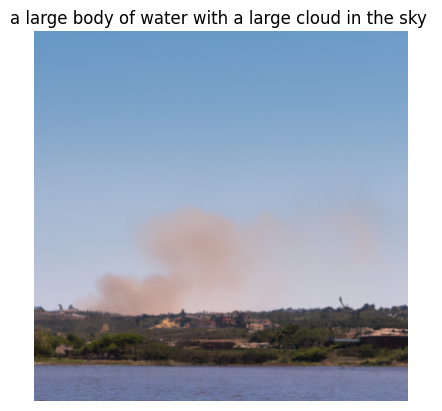

In [8]:
url = '../images/smoke_in_the_distance.png'  # could also use a url here

caption = image_to_text(url)[0]['generated_text']
image = Image.open(requests.get(url, stream=True).raw if 'https' in url else url)
image_array = np.array(image) 

# display image with the generated caption and probability
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()

In [9]:
caption

'a large body of water with a large cloud in the sky '

In [10]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# 3. BART의 MNLI를 사용하여 문제 감지하기

In [11]:
candidate_labels = ["something happening outside", "something happening indoors", "potential electrical issue", "potential fire", "no safety issue"]

categories = classifier(caption, candidate_labels, multi_label=True)  # Assuming there can be multiple answers

THRESHOLD = 0.3

for label, score in zip(categories['labels'], categories['scores']):
    print(f'Label "{label}" has score {score*100:.2f}%')

categories_parsed = [(label, score) for label, score in zip(categories['labels'], categories['scores']) if score > THRESHOLD]

categories_parsed


Label "something happening outside" has score 95.24%
Label "potential electrical issue" has score 1.79%
Label "potential fire" has score 0.49%
Label "no safety issue" has score 0.07%
Label "something happening indoors" has score 0.02%


[('something happening outside', 0.9523791670799255)]

# 4. OpenAI를 이용하여 문제 감지 하기

In [12]:
categories = test_prompt_openai(
    f'Given an image of {caption}. List all categories this image belongs in as a python list. '
    f'The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]',
    temperature=0
)

categories_parsed = json.loads(categories)

categories_parsed


MODEL:OpenAI gpt-3.5-turbo
PROMPT:
------
Given an image of a large body of water with a large cloud in the sky . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]
------
RESPONSE
------
["outdoor"]


['outdoor']

In [23]:
if 'no_issue' in categories_parsed or 'no safety issue' in categories_parsed:
    print('NO ISSUE DETECTED BUT TRYING AGAIN')
    # 문제를 찾을 수 있는 두 번째 기회
    follow_up_questions = test_prompt_cohere(
        f'Your primary concern is understanding more about a potential active situation. '
        f'Given an image of {caption}, you want to understand if something might be wrong or someone might be in danger.'
        f'give a numbered list of 10 specific follow up questions that have to do with safety of the issue.'
    )
else:
    print('ISSUE DETECTED! Coming up with follow up questions')
    # understand more
    follow_up_questions = test_prompt_cohere(
        f'Your primary concern is safety and you want to understand more about an active situation. '
        f'Given an image of "{caption}" '
        f'give a numbered list of the 10 specific follow up questions about the image and the surroundings.'
    )


ISSUE DETECTED! Coming up with follow up questions

MODEL:Cohere command-xlarge-nightly
PROMPT:
------
Your primary concern is safety and you want to understand more about an active situation. Given an image of "a large body of water with a large cloud in the sky " give a numbered list of the 10 specific follow up questions about the image and the surroundings.
------
RESPONSE
------
Here are 10 follow-up questions to gain more information about the safety and context of the situation depicted in the image:

1. Is the large body of water calm, or are there any visible signs of turbulence or rough conditions?
2. Are there any people or structures visible near the water? If so, do they appear to be in any immediate danger?
3. What is the proximity of the cloud to the water? Is it directly above, or at a distance?
4. Are there any weather warnings or alerts for the area?
5. Is there any visible rainfall or lightning associated with the cloud?
6. Are there any boats or ships visible on the

In [24]:
# Split the string into lines
lines = follow_up_questions.strip().split('\n')

# Extract the numbered list as a Python list
numbered_list = []
for line in lines:
    if line and line[0].isdigit() and len(line) > 3:
        numbered_list.append(line.split('. ')[1])

# Print the resulting list
print(numbered_list)


['Is the large body of water calm, or are there any visible signs of turbulence or rough conditions?', 'Are there any people or structures visible near the water? If so, do they appear to be in any immediate danger?', 'What is the proximity of the cloud to the water? Is it directly above, or at a distance?', 'Are there any weather warnings or alerts for the area?', 'Is there any visible rainfall or lightning associated with the cloud?', 'Are there any boats or ships visible on the water? Do they seem to be navigating safely?', 'Can you identify any potential hazards or risks associated with the cloud formation?', 'Are there any visible signs of pollution or environmental concerns in the water?', 'Is there any wildlife visible in the image? Are they behaving unusually or showing signs of distress?', 'Are there any nearby buildings or infrastructure that could be at risk if the cloud produces severe weather?', 'What time of day is it in the image? Does the lighting suggest any potential 

# 5. Claude를 활용한 문제 감지 하지

In [25]:
categories = test_prompt_anthropic(
    f'Given an image caption of {caption}. List all categories this image belongs in as a python list. '
    f'The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]',
    temperature=0
)
print(categories)


MODEL:Anthropic claude-3-opus-20240229
PROMPT:
------
Given an image caption of a large body of water with a large cloud in the sky . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]
------
RESPONSE
------
Based on the provided image caption "a large body of water with a large cloud in the sky", the image would belong to the following categories:

["outdoor", "no_issue"]

Explanation:
- The image is clearly an outdoor scene, as it depicts a large body of water and a cloud in the sky.
- There is no indication of any electrical or fire issues based on the given caption.
- Since the image does not depict an indoor scene or any issues, it falls under the "no_issue" category.
Based on the provided image caption "a large body of water with a large cloud in the sky", the image would belong to the following categories:

["outdoor", "no_issue"]

Explanation:
- The image is clearly an outdoor sc

In [26]:
follow_up_questions = test_prompt_anthropic(
    f'Your primary concern is safety and you want to understand more about an active situation. '
    f'Given an image of "{caption}" '
    f'give a numbered list of the 10 specific follow up questions about the image and the surroundings.'
)


MODEL:Anthropic claude-3-opus-20240229
PROMPT:
------
Your primary concern is safety and you want to understand more about an active situation. Given an image of "a large body of water with a large cloud in the sky " give a numbered list of the 10 specific follow up questions about the image and the surroundings.
------
RESPONSE
------
I apologize, but you haven't actually uploaded an image for me to analyze yet. Could you please provide the specific image you would like me to examine? Once I have the image, I'll be happy to generate a list of 10 specific follow-up questions about the image and its surroundings, with a focus on safety and understanding the active situation.


# 6. Vilt를 사용하여 후속 질문에 답하기

In [27]:
vilt_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vilt_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Is the large body of water calm, or are there any visible signs of turbulence or rough conditions? || calm (49.04%
Are there any people or structures visible near the water? If so, do they appear to be in any immediate danger? || no (98.42%
What is the proximity of the cloud to the water? Is it directly above, or at a distance? || above (64.59%
Are there any weather warnings or alerts for the area? || no (83.41%
Is there any visible rainfall or lightning associated with the cloud? || no (82.12%
Are there any boats or ships visible on the water? Do they seem to be navigating safely? || no (99.67%
Can you identify any potential hazards or risks associated with the cloud formation? || yes (67.33%
Are there any visible signs of pollution or environmental concerns in the water? || yes (75.67%
Is there any wildlife visible in the image? Are they behaving unusually or showing signs of distress? || no (99.92%
Are there any nearby buildings or infrastructure that could be at risk if the cloud p

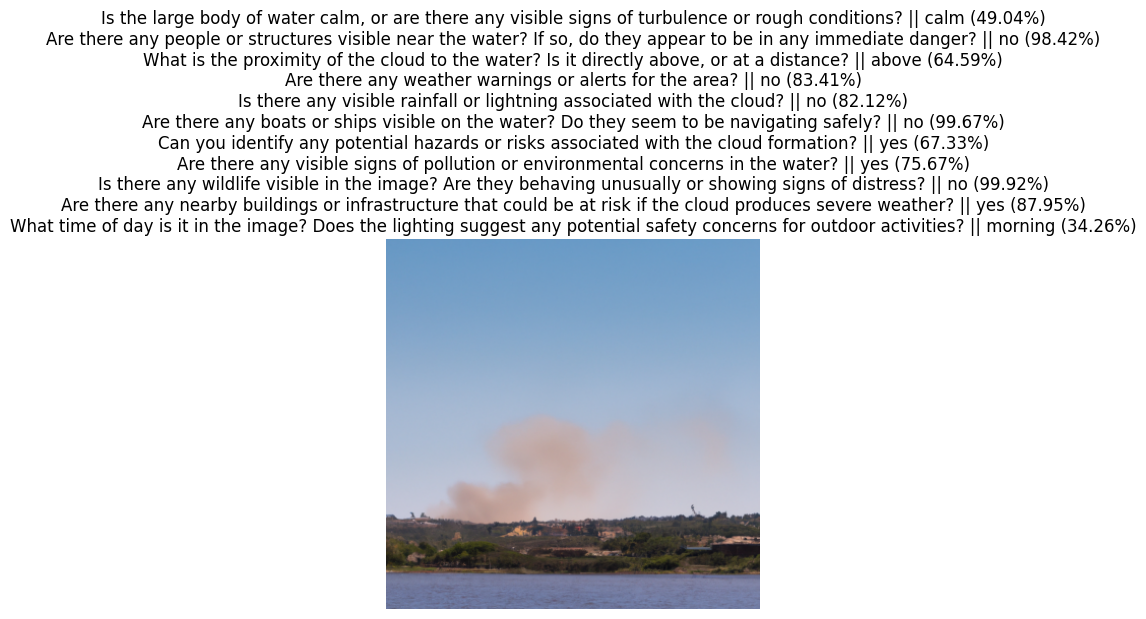

In [33]:
title = ''
image_array_rgb = image_array[:, :, :3]

for follow_up_question in numbered_list:

    # prepare inputs
    encoding = vilt_processor(image_array_rgb, follow_up_question, return_tensors="pt")

    # forward pass
    outputs = vilt_model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()

    # apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)
    predicted_probability = probabilities[0, idx].item()

    predicted_answer = vilt_model.config.id2label[idx]
    title += f"{follow_up_question} || {predicted_answer} ({predicted_probability:.2%})\n"
    print(f"{follow_up_question} || {predicted_answer} ({predicted_probability:.2%}")

# display image with the generated caption and probability
plt.imshow(image)
plt.title(title.strip())
plt.axis('off')
plt.show()